In [133]:
import json
import math
import os
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import statistics
import statsmodels.api as sm

warnings.filterwarnings('ignore')

In [134]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer as Imputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score, log_loss, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [135]:
sys.path.append(os.path.join('..', 'src'))

In [136]:
import importlib
import s05_2_feature_engineering
# importlib.reload(model)
importlib.reload(s05_2_feature_engineering)
from s05_2_feature_engineering import build_polynomials, transform_label, treat_skewness

# Data capture

In [137]:
inputs = os.path.join('..', 'data', '03_processed')
models_reports = os.path.join('..', 'data', '04_models')
model_outputs = os.path.join('..', 'data', '05_model_output')
reports = os.path.join('..', 'data', '06_reporting')

X_train           = pd.read_csv(os.path.join(inputs, 'X_train.csv'), index_col='id')
X_test            = pd.read_csv(os.path.join(inputs, 'X_test.csv'), index_col='id')
y_pred            = pd.read_csv(os.path.join(inputs, 'y_pred.csv'))
y_test            = pd.read_csv(os.path.join(inputs, 'y_test.csv'), index_col='id')

In [138]:
def plot_confusion_matrix(arr, file):
    arr = np.round(arr, 3)

    fig, ax = plt.subplots()
    im = ax.imshow(arr, cmap='Blues')

    # Loop over data dimensions and create text annotations.
    for i in range(len(arr[0])):
        for j in range(len(arr[1])):
            text = ax.text(j, i, arr[i, j],
                           ha="center", va="center", color="black")

    ax.set_title("Confusion Matrix")
    ax.set_xticks([0,1])
    ax.set_yticks([0,1])
    ax.set_xlabel('predicted label')
    ax.set_ylabel('true label')
#     fig.tight_layout()
#     plt.show();
    plt.savefig(os.path.join(reports,file), bbox_inches = "tight");

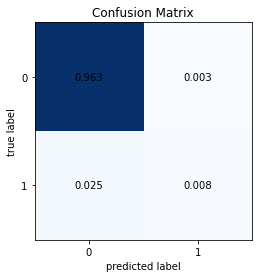

In [139]:
y_pred_thres = y_pred > 0.5
cm = confusion_matrix(y_test, y_pred_thres, normalize='all')
plot_confusion_matrix(cm, 'confusion_baseline.jpg')

# Decision making

# Sort entries
Retrieve IDs e and sort them by probability.

# compare estimated value with true value for sample

In [140]:
index_name = X_train.index.name
# y_pred = y_pred_prob
ordered_users = pd.DataFrame(list(zip(X_test.index, y_pred['y'], y_test['y'])), columns = [index_name, 'estimated probability', 'true value']).set_index(index_name)
ordered_users.sort_values(by='estimated probability', ascending=False, inplace=True)
ordered_users

,estimated probability,true value
id,,
3390348,0.972517,1.0
3378721,0.969419,1.0
3300259,0.965886,0.0
3494143,0.946366,1.0
3270767,0.928240,1.0
...,...,...
3057490,0.006263,0.0
3055966,0.006105,0.0
3375392,0.005985,0.0


Now let's see the number of observations from testset and how many of them are positive or negative.

In [141]:
users_total = len(ordered_users)
users_yes = len(ordered_users[ordered_users['true value'] == 1])
users_no = users_total - users_yes
print('Size of test set:', users_total)
print('number of positive cases:', users_yes, 'ou {}% do total'.format(round(users_yes/users_total*100, 2)))
print('number of negative cases:', users_no, 'ou {}% do total'.format(round(users_no/users_total*100, 2)))

Size of test set: 3000
number of positive cases: 101 ou 3.37% do total
number of negative cases: 2899 ou 96.63% do total


# Análise de thresholds
Let's compare the probability thresholds for decision making. Assuming 1 for positive cases, and 0 for negative ones.

### Precision Recall Curve

TP=True Positives, FP=False Positives, TN=True Negatives, and FN=False Negatives:
* Precision is given by: $\frac{TP}{TP+FP}$
* Recall (sensitivity) is given by: $\frac{TP}{TP+FN}$

FP are those cases where the model mistakenly classifies negative cases as positive. While recall measures the proportion of correctly classified as positives from the positive population (focus on FN), precision measures the proportion of true positives from the cases classified as positives (focus on FP)

There are other metrics for binary classification. For instance, ROC curve (receiver operating characteristic) shows how much of a rise of TPR (True Positive Rate) also increses FPR (False Positive Rate). Despite the usefulness of that graphic, we believe that precision-recall curve is enough.

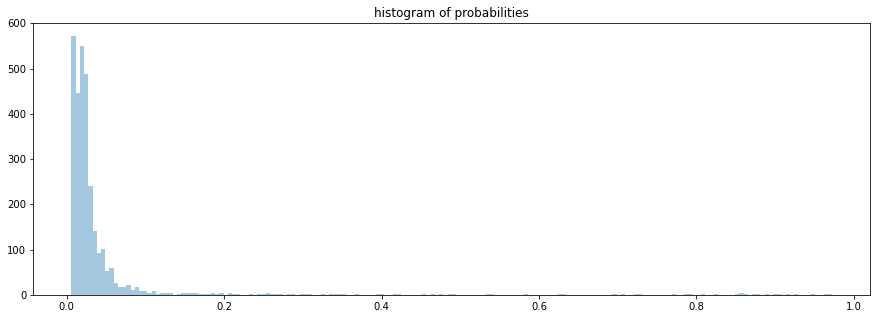

In [142]:
fig, ax1 = plt.subplots(1,1,figsize=(15,5))
ax1 = sns.distplot( y_pred, hist=True, kde=False, bins=int(180/1), ax=ax1 )
ax1.set_title('histogram of probabilities');

# save file
file = '09hist_prob.jpg'
plt.savefig(os.path.join(reports,file), bbox_inches = "tight")

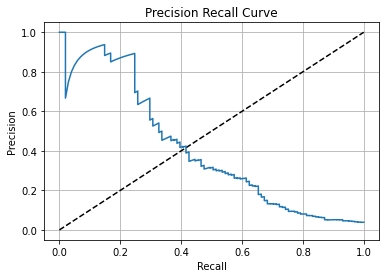

In [143]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(recalls, precisions)
plt.grid()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.show()

As we can see in this graphic, it is possible to increase recall withouth too much sacrifice in precision until the level of 0.95.

If we consider a threshold of 50%, we get a precision of 40% and reach 22% of cases of interest.

In [144]:
def print_thresholds(thres_list, thres=0.5):
    thres_index = np.where(thres_list>=thres)[0][0]
    print('threshold:', round(thres_list[thres_index],2))
    print('precision:', round(precisions[thres_index],2))
    print('recall:', round(recalls[thres_index],2))

In [145]:
print_thresholds(thresholds, thres=0.5)

threshold: 0.54
precision: 0.71
recall: 0.25


Let's reduce the threshold and see what happens

Up until now, it seems that it makes sense to lower the threshold in order to reach a higher recall.

In [146]:
print_thresholds(thresholds, thres=0.3)

threshold: 0.3
precision: 0.56
recall: 0.31


In [147]:
print_thresholds(thresholds, thres=0.15)

threshold: 0.15
precision: 0.42
recall: 0.41


In [148]:
print_thresholds(thresholds, thres=0.03)

threshold: 0.03
precision: 0.09
recall: 0.75


After reducing excessively the threshold, we might attain to cover all machine failures, but to the cost of a low precision. By assuring that all failures are prevented (no False Negative), we would be investing too much money on False Positives (by fixing machines which have low risk of failing). Depending on the costs, we risk having a lower ROI (Return on Investment).

Let's evaluate absolute values

### Build list of accumulated values

In [149]:
ordered_users['unique_prob'] = ~ordered_users.duplicated(subset = 'estimated probability', keep='last')

ordered_users['in_threshold'] = ordered_users[ (ordered_users['unique_prob'] == True) 
                                              & (ordered_users['estimated probability'].isin(thresholds)) ]['estimated probability']

unique_prob = ordered_users['unique_prob'].to_list()
in_threshold = ordered_users['in_threshold'].to_list()
ordered_users.drop(['in_threshold', 'unique_prob'], axis=1, inplace=True)

build list of cumulative values

In [150]:
ordered_users

,estimated probability,true value
id,,
3390348,0.972517,1.0
3378721,0.969419,1.0
3300259,0.965886,0.0
3494143,0.946366,1.0
3270767,0.928240,1.0
...,...,...
3057490,0.006263,0.0
3055966,0.006105,0.0
3375392,0.005985,0.0


In [151]:
cum_positive = ordered_users['true value'].cumsum().to_list()

cum_positive_filtered = []
cum_target_users = []
for i,val in enumerate(in_threshold):
    if not math.isnan(val):
        cum_value_pos = cum_positive[i]
        cum_positive_filtered.append(cum_value_pos)
        cum_target_users.append(i)
        
cum_positive_filtered = list(reversed(cum_positive_filtered))
cum_target_users = list(reversed(cum_target_users))

## Compare absolute numbers
Let's compare absolute numbers to see the real effect 

In [152]:
cum_positive_filtered.append(cum_positive_filtered[-1])
cum_target_users.append(cum_target_users[-1])

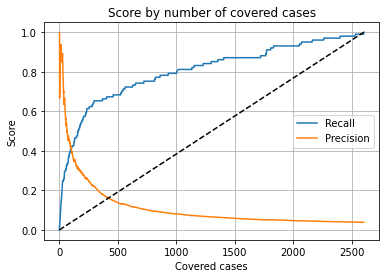

In [153]:
plt.plot(cum_target_users, recalls)
plt.plot(cum_target_users, precisions)
plt.plot([0, max(cum_target_users)], [0, 1], 'k--')
plt.grid()
plt.legend(labels  = ['Recall', 'Precision'])
plt.xlabel('Covered cases')
plt.ylabel('Score')
plt.title('Score by number of covered cases')
plt.show()

<!-- ### Compara resultados positivos com números absolutos em cada threshold
Note que essa curva é idêntica ao recall, mas é agora em número absolutos em vez de proporção. -->

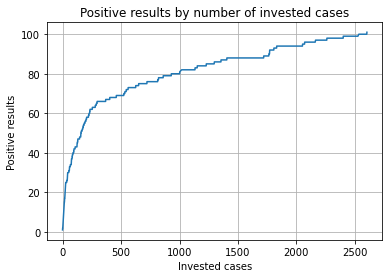

In [154]:
plt.plot(cum_target_users, cum_positive_filtered)
plt.grid()
plt.xlabel('Invested cases')
plt.ylabel('Positive results')
plt.title('Positive results by number of invested cases')
plt.show()

# change threshold for comparison

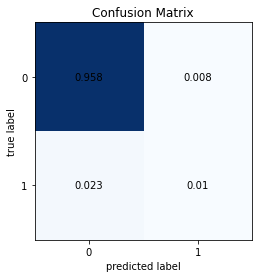

In [155]:
y_pred_thres = y_pred > 0.3
cm = confusion_matrix(y_test, y_pred_thres, normalize='all')
plot_confusion_matrix(cm, 'confusion_03.jpg')

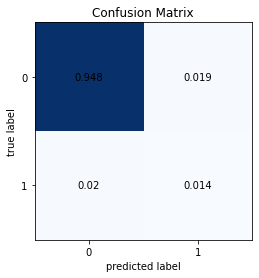

In [156]:
y_pred_thres = y_pred > 0.15
cm = confusion_matrix(y_test, y_pred_thres, normalize='all')
plot_confusion_matrix(cm, 'confusion_015.jpg')

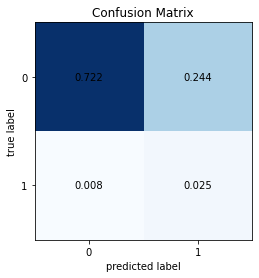

In [157]:
y_pred_thres = y_pred > 0.03
cm = confusion_matrix(y_test, y_pred_thres, normalize='all')
plot_confusion_matrix(cm, 'confusion_003.jpg')